In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import PathPatch

In [2]:
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [3]:
fp_data = "../results/metrics/"
FNs1 = glob.glob(fp_data+"Metric*AllOnes*adj*.tsv")
FNs2 = glob.glob(fp_data+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs3 = glob.glob(fp_data+"Metric*AllOnes*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs1 + FNs2 + FNs3
fp_data2 = "../results/ortholog_metrics/"
FNs1 = glob.glob(fp_data2+"Metric*AllOnes*adj*.tsv")
FNs2 = glob.glob(fp_data2+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs + FNs1 + FNs2
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    if df_tmp.shape[0] == 0:
        # this is for dr BioGRID where there are no terms
        continue
    # remove hs_mm that has AllOnes embeddings
    if ("AllOnes" in aFN) and ("hs_mm" in aFN) and ("Pecanpy" in aFN):
        continue
    GSCtmp = "_".join(df_tmp["GSC_info"].to_list()[0].split("__")[1].split("_")[0:2])
    df_tmp["GSC"] = [GSCtmp] * df_tmp.shape[0]
    df_results = pd.concat([df_results,df_tmp])
df_results.head()

,GSC_info,network,species,connections,feature_type,model_info,ID,name,num_train_pos,num_train_all,num_test_pos,num_test_all,avgp,log2p,auroc,PTopK,GSC
0,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000041,transition metal ion transport,37,6141,12,3117,0.008175,1.086335,0.565781,0,GO_mm
1,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000209,protein polyubiquitination,22,6112,19,3092,0.013992,1.187160,0.631373,0,GO_mm
2,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000724,double-strand break repair via homologous reco...,14,5898,10,3035,0.031852,3.273073,0.853025,0,GO_mm
3,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0001578,microtubule bundle formation,15,6005,34,2988,0.064481,2.502510,0.800370,3,GO_mm
4,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0001825,blastocyst formation,43,5865,13,3089,0.010738,1.351374,0.699510,0,GO_mm


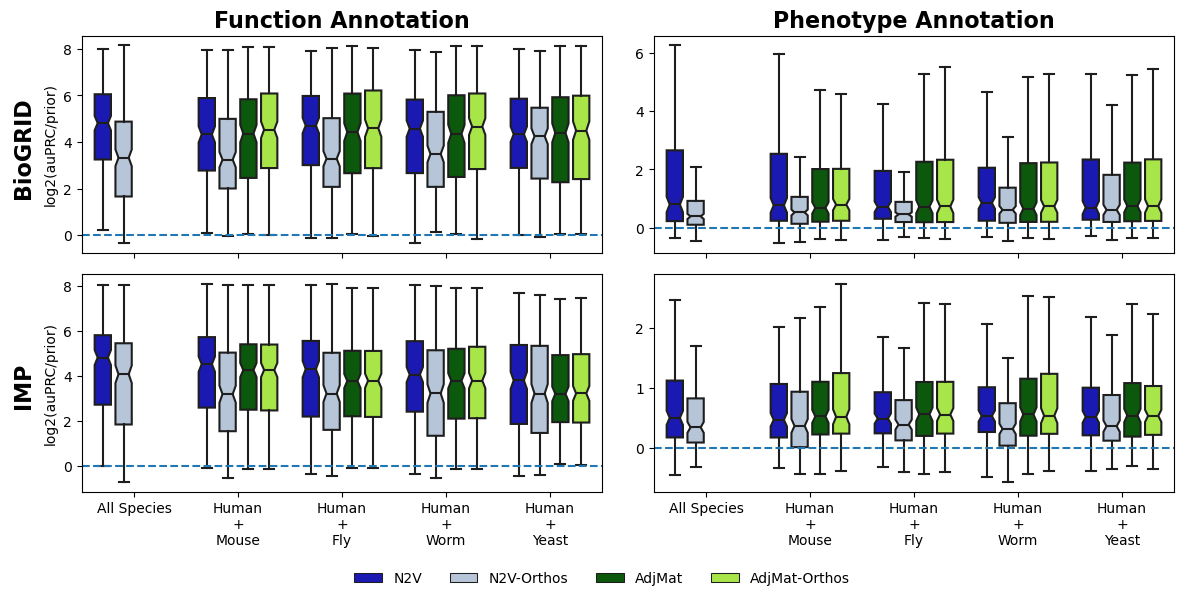

In [4]:
%%capture --no-display
def make_plots3():
    fig, ax = plt.subplots(2,2,figsize=(12,6))
    for idx2, anet in enumerate(["BioGRID_raw","IMP_raw"]):
        for idx1, aGSC in enumerate(["GO", "Monarch"]):
            df_tmp = df_results[(df_results["network"]==anet)&
                                (df_results["GSC"]==f"{aGSC}_hs")]
            species_tmp = df_tmp["species"].to_list()
            features_tmp = df_tmp["feature_type"].to_list()
            new_hue = []
            new_xlabel = []
            for idx, item in enumerate(species_tmp):
                if features_tmp[idx] == "adj":
                    if "orthos" in item:
                        new_hue.append("AdjMat-Orthos")
                    else:
                        new_hue.append("AdjMat")
                else:
                    if "orthos" in item:
                        new_hue.append("N2V-Orthos")
                    else:
                        new_hue.append("N2V")
                if "ce_dm" in item:
                    new_xlabel.append("All Species")
                elif "_" not in item:
                    new_xlabel.append("Human\nOnly")
                elif "ce_hs" in item:
                    new_xlabel.append("Human\n+\nWorm")
                elif "dm_hs" in item:
                    new_xlabel.append("Human\n+\nFly")
                elif "dr_hs" in item:
                    new_xlabel.append("Human\n+\nFish")
                elif "hs_mm" in item:
                    new_xlabel.append("Human\n+\nMouse")
                elif "hs_sc" in item:
                    new_xlabel.append("Human\n+\nYeast")
            df_tmp["hue"] = new_hue
            df_tmp["xlabel"] = new_xlabel
            sns.boxplot(data=df_tmp,x="xlabel",y="log2p",hue="hue",
                        notch=True,showfliers=False,ax=ax[idx2,idx1],
                        order=["All Species","Human\n+\nMouse","Human\n+\nFly",
                               "Human\n+\nWorm","Human\n+\nYeast"],
                        hue_order = ["N2V","N2V-Orthos","AdjMat","AdjMat-Orthos"],
                        palette = ["mediumblue","lightsteelblue","darkgreen","greenyellow"])
            ax[idx2,idx1].get_legend().remove()
            ax[idx2,idx1].axhline(ls="--")
            ax[idx2,idx1].set_xlabel("")
            if idx2 == 0:
                ax[idx2,idx1].set_xticklabels("")
            else:
                ax[idx2,idx1].set_xticklabels(ax[idx2,idx1].get_xticklabels(),fontsize=10)
            if idx1 == 1:
                ax[idx2,idx1].set_ylabel("")
            else:
                ax[idx2,idx1].set_ylabel("log2(auPRC/prior)",fontsize=10)
    ax[0,0].set_title("Function Annotation",fontsize=16,fontweight="bold")
    ax[0,1].set_title("Phenotype Annotation",fontsize=16,fontweight="bold")
    plt.annotate("BioGRID",xy=(0.01,0.68),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.annotate("IMP",xy=(0.01,0.33),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.subplots_adjust(bottom=0.18,hspace=0.1,wspace=0.1,left=0.07,right=0.98,top=0.94)
    ax[1,1].legend(ncol=5, loc = "center", bbox_to_anchor=(-0.1, -0.4), \
        frameon=False, fontsize=10)
    adjust_box_widths(fig, 0.8)
    fig.savefig('../figures/FigSM8.pdf')
make_plots3()